# Backends

The `lens-api` library supports several common machine learning libraries, including Keras, Pytorch, and TensorFlow.

In order to set the backend to the backend of your choice, use the `NETLENS_BACKEND` flag. In this demo, we will be using the Keras backend, so we run the following *before* our NetLens imports:

In [1]:
import os
os.environ['NETLENS_BACKEND'] = 'tensorflow'

# Attributions

## Model Wrappers

In order to support a wide variety of backends with different interfaces for their respective models, NetLens uses its own `Model` class which provides a general model interface to simplify the implementation of the API functions. A model wrapper class exists for each backend that converts a model in the respective backend's format to the general NetLens `Model` interface. The wrappers are found in the `models` module, and any model defined using Keras, Pytorch, or Tensorflow should be wrapped with the appropriate wrapper before being used with the other API functions that require a model -- all other NetLens functionalities expect models to be an instance of `netlens.models.Model`.

For this demo, we will be using a Keras model pre-trained on Imagenet. 

In [2]:
# TODO: get rid of this once we have netlens in the virtual environment.
import sys
sys.path.append('..')

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from netlens.models.keras import KerasModelWrapper

import numpy as np
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
disable_eager_execution()

In [5]:
keras_model = VGG16(weights='imagenet')
keras_model.summary()

# Produce a wrapped model from the keras model.
model = KerasModelWrapper(keras_model)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now that we've loaded our model, lets take a quick look at its predictions on the following instance:

[[('n02088364', 'beagle', 0.49533594),
  ('n02088238', 'basset', 0.1643161),
  ('n02089973', 'English_foxhound', 0.05349689),
  ('n02089867', 'Walker_hound', 0.046594027),
  ('n02107574', 'Greater_Swiss_Mountain_dog', 0.02669805)]]

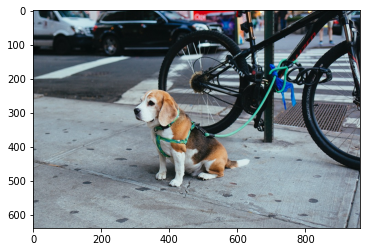

In [6]:
# Load the example instance.
with PIL.Image.open('doggo_bike.jpg') as img:
    # View the image.
    plt.imshow(img)
    
    x = np.array(img.resize((224,224), PIL.Image.ANTIALIAS))[np.newaxis]
    
    # Save a pre-processed version for the network's consumption.
    x_pp = preprocess_input(np.array(x, copy=True))

# Pretty-print the model's top 5 predictions on this instance.
decode_predictions(keras_model.predict(x_pp))

In the next section, we'll show how to use the NetLens API to further investigate the model's predictions on this instance.

## Attribution Methods

*Attribution methods*, in the most general sense, allow us to quantify the contribution of particular variables in a model towards a particular behavior of the model. 
In many cases, for example, this may simply measure the effect each input variable has on the output of the network.

Attribution methods extend the `AttributionMethod` class, and many concrete instances are found in the `attribution` module.

Once an attribution method has been instantiated, its main function is its `attributions` method, which takes an `np.Array` of batched instances, where each instance matches the shape of the input to the model the attribution method was instantiated with.
In this demo, we will mostly make use of the `InternalInfluence` attribution method, as it is the most general, though we will compare it briefly with the other methods.
See the [method comparison demo]() for further information on the different types of attribution methods, their uses, and their relationships with one another.

### Getting started: Saliency Maps and Integrated Gradients

The first methods that we will examine directly measure the importance of input features on the classification of the model. These are the most straightforward type of attributions to compute, as there are relatively few choices to make.

* _Saliency maps_ take the gradient of the network's predicted class on a given input. See the reference by Simonyan et al. given below for more details and discussion of this method.
* _Integrated gradients_ addresses some issues with saliency maps described by Sundararajan et al., and proposes a way of addressing them by aggregating the gradient on a linear subspace of the model's input features. Because this aggregation cannot be computed exactly in general, the implementation evaluates the gradient on a specified number of samples.

We will see how to use each of these methods using the API, and how to visualize the results.

---
Karen Simonyan, Andrea Vedaldi, Andrew Zisserman. *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*. ICLR 2014. [ArXiv](https://arxiv.org/pdf/1312.6034.pdf)

Mukund Sundararajan, Ankur Taly, Qiqi Yan. *Axiomatic Attribution for Deep Networks* [PMLR](http://proceedings.mlr.press/v70/sundararajan17a/sundararajan17a.pdf)


In [7]:
from netlens.attribution import InputAttribution
from netlens.attribution import IntegratedGradients
import netlens.backend as B

Saliency maps are implemented by the `InputAttribution` class. This takes several optional arguments, the meaning of which we will discuss later in this notebook. The provided defaults instantiate an `AttributionMethod` that is consistent with the method described in the reference above.

The required argument to the constructor is a `ModelWrapper`. After constructing the attribution method, we call it on our data point, and receive an array containing the attributions.

In [8]:
infl = InputAttribution(model)
attrs_input = infl.attributions(x_pp)

To visualize the attributions, we can use `MaskVisualizer` from the `visualizations` module. This class takes a `blur` and `threshold` argument, and allows us to overlay a partially-opaque mask over a given image that reveals the top-threshold percentage of pixels by attribution, after applying a Gaussian blur of the given radius.

In [9]:
from netlens.visualizations import MaskVisualizer

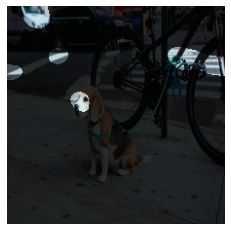

In [10]:
masked_image = MaskVisualizer(blur=10, threshold=0.95)(attrs_input, x)

Turning to Integrated Gradients, the workflow for obtaining attributions is nearly identical. The only difference is that the `AttributionMethod` instance we construct is one of `IntegratedGradients` rather than `InputGradients`.

The `resolution` argument, which is optional and defaults to 50, specifies the number of samples to take. Larger values approximate the true aggregate quantity more closely, and in practical terms, tend to be more stable.

Another optional argument is the `baseline`, which specifies the linear subspace over which the quantity is aggregated. By default this is `None`, which is interpreted as an appropriately-sized zero tensor. In this case the linear subspace is the line between this zero tensor, and the point for which the attributions are computed.

In [11]:
infl = IntegratedGradients(model, resolution=10)
attrs_input = infl.attributions(x_pp)

Visualizing the results, it is apparent that Integrated Gradients in this case is better able to focus on the pixels corresponding to the beagle, which is consistent with the model's top predicted class.

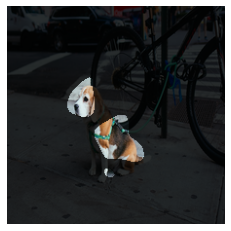

In [12]:
masked_image = MaskVisualizer(blur=10, threshold=0.95)(attrs_input, x)

### Discovering Important Internal Neurons 

The first attribution method we'll examine is *Internal Influence* (Leino et al.), a powerful and general attribution method that can calculate attributions for internal neurons in a network as well as for the inputs to the network. Internal Influence is implemented by the `InternalInfluence` class in the `attribution` module.

The `InternalInfluence` constructor takes a NetLens `Model` and three special parameters: a *slice*, a *quantity of interest* (QoI), and a *distribution of interest* (DoI), which are instances of the `Slice` (in the `slices` module), `QoI` (in the `quantities` module), and `DoI` (in the `distributions` module) classes, respectively.

The slice essentially defines a layer to use for internal attributions. A `Slice` object specifies two layers: (1) the layer of the variables that we are calculating attribution *for* (e.g., the input layer), and (2) the layer whose output defines our quantity of interest (e.g., the output layer; see below for more on quantities of interest).

The quantity of interest (QoI) essentially defines the model behavior we would like to explain using attributions. The QoI is a function of the model's output at some layer. For example, it may select the confidence score for a particular class. In its most general form, the QoI can be pecified by an implementation of the `QoI` class in the `quantities` module. Several common default implementations are provided in this module as well.

The distribution of interest (DoI) essentially specifies for which points surrounding each instance the calculated attribution should be valid. The distribution can be specified via an implementation of the `DoI` class in the `distributions` module, which is a function taking an input instance and producing a list of input points to aggregate attribution over. A few common default distributions implementing the `DoI` class can be found in the `distributions` module.

See the [parameterization demo]() for further explanations of the purpose of these parameters and examples of their usage.



---

* Klas Leino, Shayak Sen, Anupam Datta, Matt Fredrikson, and Linyi Li. *Influence-Directed Explanations for Deep Convolutional Networks*. IEEE ITC 2018. [ArXiv](https://arxiv.org/pdf/1802.03788.pdf)

In [13]:
from netlens.attribution import InternalInfluence
from netlens.distributions import PointDoi
from netlens.quantities import ClassQoI, InternalChannelQoI, MaxClassQoI
from netlens.slices import Cut

We will be calculating attributions for the feature maps in layer -10 of our model (specified via the slice below). In our first example, we are interested in explaining the model's *predicted class* for our instance. We specify this by using a `MaxClassQoI`, which sets the attributions to explain the model's output for its highest-confidence class. We will initially use the `PointDoI` which specifies that we are only concerned with the model's behavior on one particular point, i.e., we want a very *local* explanation.

In [14]:
# Define the influence measure.
infl = InternalInfluence(
    model, 
    Cut(-10), 
    MaxClassQoI(),
    PointDoi())

# Get the attributions for the internal neurons at layer -10. Because layer -10
# contains 2D feature maps, we take the sum over the width and height of the 
# feature maps to obtain a single attribution for each feature map.
attrs_internal = infl.attributions(x_pp).sum(axis=(1,2))

Note that above we used the `Slice`, `MaxClassQoI`, and `PointDoI` classes to define the slice, QoI, and DoI. The NetLens API also offers several simple shorthands for defining these parameters more simply. For example, the above code could be more succinctly written as

In [15]:
# Define the influence measure.
infl = InternalInfluence(model, Cut(-10), 'max', 'point')

# Get the attributions for the internal neurons at layer -10. Because layer -10
# contains 2D feature maps, we take the sum over the width and height of the 
# feature maps to obtain a single attribution for each feature map.
attrs_internal = infl.attributions(x_pp).sum(axis=(1,2))

Now we can calculate the most important feature map towards the model's top prediction, by taking the argmax over the internal attributions for this instance. The most important feature map represents some type of *learned feature* that was the *most important* in the network's decision to label this point as `671: 'mountain bike, all-terrain bike, off-roader'`.

In [16]:
# TODO(klas): it would be good to make it so we don't have to do `int`. I think
#   the issue is that we're getting an int64 or something, which isn't being
#   caught in our constructor method.
top_feature_map = int(attrs_internal[0].argmax())

print('Top feature map:', top_feature_map)

Top feature map: 467


### Visualizing Important Internal Neurons

We would now like to visualize our identified feature map in a meaningful way. Since the feature map represents a learned feature, which is not readily interpretable, we will use a second set of attributions to identify the input features that are most important in defining this particular feature map. We will then use a *visualizer*, found in the `visualizations` module, to visualize these input features that relate to our identified important feature map.

In [17]:
from netlens.visualizations import MaskVisualizer

import netlens.backend as B

First, we create another attributer, again using `InternalInfluence`. This time, we specify our slice to begin at the input of the model (layer 0) and end at layer -10, the layer of our identified feature map. We select our quantity of interest to be an `InternalChannelQoI` - this allows us to specify a particular channel that we want to calculate attributions towards (in our case we specify this channel to be our identified feature map). We will again use the `Point` DoI.

In [18]:
infl_input = InternalInfluence(
    model, 
    (Cut(0), Cut(-10)),
    InternalChannelQoI(top_feature_map), 
    PointDoi())

# NOTE: was
#
# infl_input = InternalInfluence(
#     model, 
#     Slice.from_layer_indices(model, 0, -10),
#     InternalChannelQoI(top_feature_map, agg_fn=B.max), 
#     PointDoi())
#
# but we can't simplify the syntax much because of agg_fn. I'm not sure the 
# agg_fn is necessary.

Again, the above code can be simplified to

In [19]:
infl_input = InternalInfluence(model, (Cut(0), Cut(-10)), top_feature_map, 'point')

Now we can calculate the input attributions and visualize the top feature map by using the input attributions as a mask over the original image, using the `MaskVisualizer` (found in the `visualizations` module).

The `MaskVisualizer` takes two fine-tuning parameters, `blur` and `threshold`, that affect the quality of the visualization. The attributions are first blurred using a Gaussian blur with radius `blur`, and then only the pixels whose blurred attribution value are at or above the percentile given by `threshold` are highlighted. Depending on the particular instance and application, different `blur` and `threshold` parameters may be appropriate.

Increasing `blur` gives a more abstract, region-focused explanation, while a smaller blur gives a noisier, but more precise explanation.

Increasing `threshold` selects a smaller portion of the image to highlight, showing only the most important regions, while a smaller threshold will highlight a larger portion of the image.

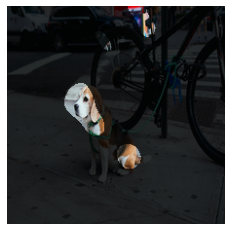

In [20]:
attrs_input = infl_input.attributions(x_pp)

masked_image = MaskVisualizer(blur=10, threshold=0.95)(attrs_input, x)

The above procedure &mdash; using a second set of attributions to identify the input features that are most important in defining a particular feature map, then using a visualizer on the resulting input attributions &mdash; is a common use case when dealing with internal attributions. This procedure can instead be done via a single step, using a `ChannelMaskVisualizer` also found in the `visualizations` module, demonstrated below.

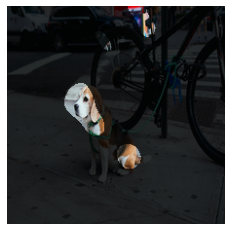

In [21]:
from netlens.visualizations import ChannelMaskVisualizer

masked_image = ChannelMaskVisualizer(
    model,
    -10,
    top_feature_map,
    blur=10, 
    threshold=0.95)(x, x_pp)
plt.axis('off')
plt.imshow(masked_image[0])

#### Other Quantities of Interest

We can also change the quantity that we want the attributions to explain. For example, our example image contains both a bike and a dog. Recall that while the top class predicted by our model was `671: 'mountain bike, all-terrain bike, off-roader'`, our model also predicted a few dog-related classes in its top five predictions, of which the top was `249: 'malamute, malemute, Alaskan malamute'`. We can follow essentially the same steps as above to explain the model's prediction for the class `249: 'malamute, malemute, Alaskan malamute'`. We will use the `ClassQoI` to accomplish this.

Top feature map: 491


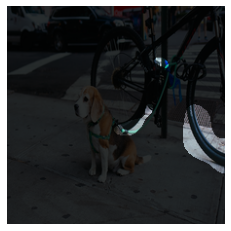

In [22]:
# Define the influence measure.
infl_dog = InternalInfluence(model, Cut(-10), 249, 'point')

# The above is shorthand for
#
# infl_dog = InternalInfluence(
#     model, 
#     -10,
#     ClassQoI(249), 
#     'point')

# Get the attributions for each feature map.
attrs_dog_internal = infl_dog.attributions(x_pp).sum(axis=(1,2))

# Find the index of the top feature map.
top_feature_map_dog = int(attrs_dog_internal[0].argmax())

print('Top feature map:', top_feature_map_dog)

# Visualize the top feature map in the input space.
masked_image = ChannelMaskVisualizer(
    model,
    -10,
    top_feature_map_dog,
    blur=10, 
    threshold=0.95)(x, x_pp)
plt.axis('off')
plt.imshow(masked_image[0])